# Exercise 2.1

In [2]:
using DistMesh
using Plots
using SparseArrays
using Polynomials

In [3]:
function xy(x0::Float64, y0::Float64, L1::Float64, L2::Float64, noelms1::Int64, noelms2::Int64)
    # Computes the x-coordinates and y-coordinates in a given range, with a given grid definition.
    # Author: Clara Hollenbeck
    # x0, y0: minimum x and y value
    # L1, L", maximum x and y value respectively
    # noelms1, noelms2: no. of elements in the x and y direction respectively.

    VX= repeat(collect(LinRange(x0, x0 + L1, noelms1+1)), inner = noelms2+1)
    VY = repeat(collect(LinRange(y0 + L2, y0, noelms2+1)), noelms1+1)
    return VX, VY
end

xy (generic function with 1 method)

In [4]:
function conelmtab(noelms1::Int64, noelms2::Int64)
    novertices = noelms1 *noelms2*2
    EToV = zeros(Int64, novertices, 3)

    for i in 1: noelms1
        v1 = collect(range(1, noelms2)) .+ (noelms2+1)*(i-1)
        v2 = collect(range(noelms2 + 3, 2*noelms2+2)) .+ (noelms2+1)*(i-1)
        v3 = collect(range(noelms2 + 2, 2*noelms2 +1)) .+ (noelms2+1)*(i-1)
        v4 = collect(range(2 , noelms2+1)) .+ (noelms2+1)*(i-1)

        
        EToV[1 + noelms2*2 *(i-1) : noelms2*2 *i , :] = vcat(hcat(v1,v2,v3), hcat(v1, v4, v2))

    end
    return EToV[sortperm(EToV[:, 1]), :]

end


conelmtab (generic function with 1 method)

# Exercise 2.2

In [5]:
function basfun(n,VX,VY,EToV)
    i1 = EToV[n,1]
    i2 = EToV[n,2]
    i3 = EToV[n,3]
    abc = zeros(3,3)

    m = 1
    
    for (j, k) in ((i2, i3), (i3, i1), (i1, i2))
        abc[m, 1] = VX[j]*VY[k] - VX[k]*VY[j] 
        abc[m, 2] = VY[j] - VY[k] 
        abc[m, 3] = VX[k]- VX[j] 
        m += 1
    end


    delta = 1/2 *(abc[1,1] + abc[2,1] + abc[3,1])
    return abc, delta

end

basfun (generic function with 1 method)

In [5]:
function  outernormal(n::Int64,k::Int64,VX::Vector,VY::Vector,EToV::Matrix)
    k2 = k%3 +1
    dx =  VX[EToV[n, k2]] - VX[EToV[n, k]]
    dy =  VY[EToV[n, k2]] - VY[EToV[n, k]]

    norm = [dy; -dx]./sqrt(dx^2+dy^2)

    return norm
end

function  outernormal(n::Vector{Int64},k::Vector{Int64},VX::Vector,VY::Vector,EToV::Matrix)
    return outernormal.(n,k, Ref(VX),Ref(VY),Ref(EToV))
end

outernormal (generic function with 2 methods)

In [6]:
n = 4
k = 2
x0 = -2.5
y0 = -4.8
L1 = 7.6
L2 = 5.9
noelm1 = 4
noelm2 = 3
VX, VY = xy(x0, y0, L1, L2, noelm1, noelm2)
EToV = conelmtab(noelm1, noelm2)
abc, delta = basfun(n, VX, VY, EToV)
norm = outernormal(n,k,VX,VY,EToV)
display(abc)
display(delta)
display(norm)

3×3 Matrix{Float64}:
  5.38333   0.0       1.9
 -6.56333  -1.96667  -1.9
  4.91667   1.96667   0.0

1.8683333333333332

2-element Vector{Float64}:
  0.0
 -1.0

# Exercise 2.3

In [6]:
function assembly(VX,VY,EToV,lam1,lam2,qt)
    M = length(VX)
    N, _ = size(EToV)

    A = zeros(M,M)
    b = zeros(M)

    for n in 1:N
        abc, delta = basfun(n, VX, VY, EToV)
        q = abs(delta)/9* sum(qt[EToV[n, :]])

        for r in 1:3
            i = EToV[n,r]
            b[i] += q
            
            for s in 1:3
                j = EToV[n,s]
                kn = 1/(4*abs(delta))*(lam1*abc[r,2]*abc[s,2] + lam2*abc[r,3]*abc[s,3])
                A[i,j] += kn 
            end
        end
    end
    return A, b

end

assembly (generic function with 1 method)

# Exercise 2.4

In [7]:
function dirbc(bnodes,f,A,b)
    M = length(b)
   
    for (k,i) in enumerate(bnodes)
        b[i] = f[k]
        A[i, i] = 0

        idx = findall(!iszero, A[:, i])
        b[idx] .-= A[idx, i].*f[k]  
        A[idx, i] .= 0
        A[i, idx] .= 0

        A[i,i] = 1
 
    end
    return A, b
end


dirbc (generic function with 1 method)

In [9]:
#=
x0, y0 = (0.0,0.0)
L1, L2 = (1.0,1.0)
noelm1, noelm2 = (4,4)
q(x,y) = 0
=#

n = 4
k = 2
x0 = -2.5
y0 = -4.8
L1 = 7.6
L2 = 5.9
noelm1 = 4
noelm2 = 3
q(x,y) = -6x + 2y - 2
f(x,y) = x^3 - x^2*y + y^2 - 1



lam1= 1
lam2 = 1
VX, VY = xy(x0, y0, L1, L2, noelm1, noelm2)
EToV = conelmtab(noelm1, noelm2)

bnodes = union(reduce(vcat, [findall(VX .== x0 ), findall(VY.== y0), findall((VX .== (L1+x0 ))), findall(VY.== (L2+y0))]))
qs = q.(VX, VY)
ft = f.(VX[bnodes], VY[bnodes])


A, b = assembly(VX,VY,EToV,lam1,lam2,qs)
A ,b = dirbc(bnodes,ft,A,b)


spy(A, markersize = 5)
display()



# Exercise 2.5

In [8]:
function solveBVP(x0, y0, L1, L2, noelm1, noelm2, q, f)
    VX, VY = xy(x0, y0, L1, L2, noelm1, noelm2)
    EToV = conelmtab(noelm1, noelm2)

    bnodes = union(reduce(vcat, [findall(VX .== x0 ), findall(VY.== y0), findall((VX .== (L1+x0 ))), findall(VY.== (L2+y0))]))
    ft = f.(VX[bnodes], VY[bnodes])
    qt= q.(VX, VY)

    
    A, b = assembly(VX,VY,EToV,1,1,qt)
    A ,b = dirbc(bnodes,ft,A,b)

    u = A\b

    error = maximum(abs, u .- f.(VX, VY))
    return u, error
end

solveBVP (generic function with 1 method)

-1.9700959376440124

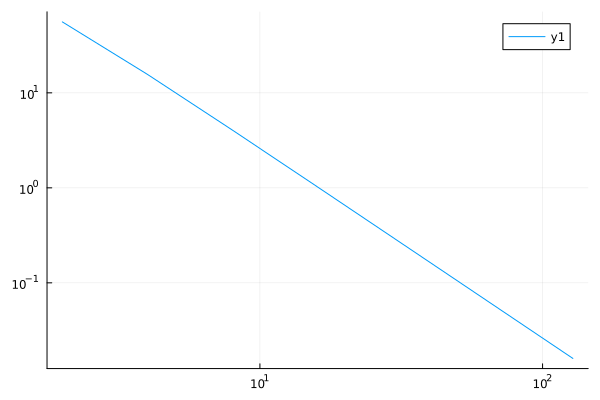

In [11]:
u(x,y) = x^3 - x^2*y + y^2 - 1
q(x,y) = -(6*x -2*y + 2)


u(x,y) = x^2*y^2
q(x,y) = -(2*y^2 + 2*x^2)


x0 = -2.5
y0 = -4.8
L1 = 7.6
L2 = 5.9
noelm1 = 4
noelm2 = 4
N = 7
es = zeros(N)
noelm = zeros(Int64, N)

for i in 1:N
    noelm[i] = 2^i
    

    us, e = solveBVP(x0, y0, L1, L2, noelm[i], noelm[i], q, u)
    es[i] = e


end

display(fit(log10.(noelm), log10.(es), 1)[1])
plot(noelm, es,  xaxis=:log10, yaxis=:log10)








# Exercise 2.6

In [9]:
function ConstructBeds(VX,VY,EToV,tol, fd)
    xc = 0.5 .*(VX[EToV] .+ VX[EToV[:, [2, 3, 1]]])
    yc = 0.5 .*(VY[EToV] .+ VY[EToV[:, [2, 3, 1]]])

    beds = getindex.(findall(abs.(fd.(xc, yc)) .<= tol), [1 2])
    return beds
end

ConstructBeds (generic function with 1 method)

In [10]:
function ConstructBnodes(VX,VY,EToV,tol, fd)
    return findall(abs.(fd.(VX,VY)) .<= tol)
end

ConstructBnodes (generic function with 1 method)

In [14]:
#=
function neubc(VX,VY,EToV,beds,q,b)
    i = EToV[CartesianIndex.(beds[:,1], beds[:,2])]
    j = EToV[CartesianIndex.(beds[:,1], beds[:,2].%3 .+ 1)]

    q1 = q.*sqrt.((VX[j]-VX[i]).^2+(VX[j]+ VX[i]).^2)./2

    b[i] -= q1
    b[j] -= q1
    
    return b
end
=#

In [11]:
function edgeIndices(
    EToV::Matrix{Int64},
    beds::Matrix{Int64},
)::Tuple{Vector{Int64}, Vector{Int64}}
    n = beds[:, 1]
    r = beds[:, 2]
    s = r .% 3 .+ 1

    i = EToV[CartesianIndex.(n, r)]
    j = EToV[CartesianIndex.(n, s)]

    return i,j
end

function neubc(
    VX::Vector{Float64},
    VY::Vector{Float64},
    EToV::Matrix{Int64},
    beds::Matrix{Int64},
    q::Vector{Float64},
    b::Vector{Float64}
)::Vector{Float64}
    i, j = edgeIndices(EToV, beds)
    q1 = q .* sqrt.((VX[j] - VX[i]).^2 + (VY[j] - VY[i]).^2) ./ 2

    b[i] -= q1
    b[j] -= q1

    return b
end

neubc (generic function with 1 method)

# Exercise 2.7

In [12]:
function solveNDBVP(VX, VY, EToV, qt, q, f, distN, distD, tol = 0.001, lam1=1, lam2 = 1)
    
    qts= qt.(VX, VY)
    A, b = assembly(VX,VY,EToV,lam1,lam2,qts)


    bnodes = ConstructBnodes(VX,VY,EToV,tol, distD)
    beds = ConstructBeds(VX, VY, EToV, tol, distN)

    i = EToV[CartesianIndex.(beds[:,1], beds[:,2])]
    j = EToV[CartesianIndex.(beds[:,1], beds[:,2].%3 .+ 1)]

    qs = q.(VX[i], VY[i], VX[j], VY[j])
    ft = f.(VX[bnodes], VY[bnodes])

    b = neubc(VX,VY,EToV,beds,qs,b)
    
    A, b = dirbc(bnodes,ft,A,b)


    u = A\b
    error = maximum(abs, u .- f.(VX, VY))
    
    return u, error
end

solveNDBVP (generic function with 4 methods)

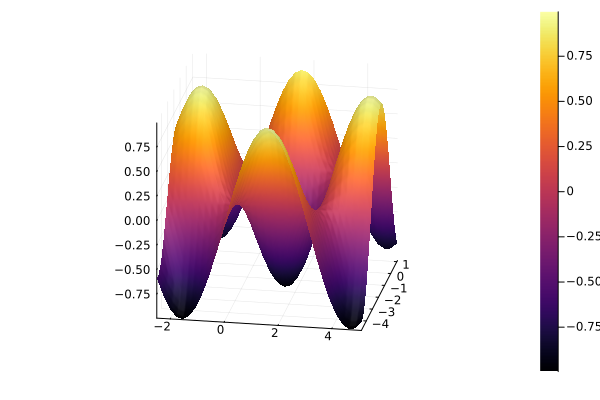

In [19]:
# Parameters
x0 = -2.5
y0 = -4.8
L1 = 7.6
L2 = 5.9
noelm1 = 32
noelm2 = 32
qt(x,y) = 2*sin(x)*sin(y)
f(x,y) = sin(x)*sin(y)

ux(x,y) = cos(x)*sin(y)
uy(x,y) = sin(x)*cos(y)

function q(x1, y1, x2, y2)
    dx = x2-x1
    dy = y2 - y1

    norm = sqrt(dx^2 + dy^2)
    n1 = dy/norm
    n2 = -dx/norm

    xc = (x1 + x2)/2
    yc = (y1 + y2)/2

    return -(ux(xc, yc)*n1 +uy(xc, yc)*n2)
end

VX, VY = xy(x0, y0, L1, L2, noelm1, noelm2)
EToV = conelmtab(noelm1, noelm2)
distN(x, y) = min(x-x0, y-y0)
distD(x, y) = min(x0+L1-x, y0+L2-y)

us, e = solveNDBVP(VX, VY, EToV, qt, q, f, distN, distD)

#display(us)

#display(e)
p1 = plot(VX[:], VY[:], us, st=:surface,camera=(10,20))
p2 = plot(VX[:], VY[:], f.(VX, VY), st=:surface,camera=(10,20))

#display(p1)
#display(p2)






In [23]:
# Parameters
x0 = -2.5
y0 = -4.8
L1 = 7.6
L2 = 5.9
noelm1 = 32
noelm2 = 32
qt(x,y) = 2*sin(x)*sin(y)
f(x,y) = sin(x)*sin(y)

ux(x,y) = cos(x)*sin(y)
uy(x,y) = sin(x)*cos(y)

function q(x1, y1, x2, y2)
    dx = x2-x1
    dy = y2 - y1

    norm = sqrt(dx^2 + dy^2)
    n1 = dy/norm
    n2 = -dx/norm

    xc = (x1 + x2)/2
    yc = (y1 + y2)/2

    return -(ux(xc, yc)*n1 +uy(xc, yc)*n2)
end
N = 8
es = zeros(N-2)
noelm = zeros(Int64, N-2)

for i in 1:N-2
    j = i+2
    noelm[i] = 2^j
    VX, VY = xy(x0, y0, L1, L2, noelm[i], noelm[i])
    EToV = conelmtab(noelm[i], noelm[i])    

    us, e = solveNDBVP(VX, VY, EToV,qt, q, f, distN, distD)
    es[i] = e


end

display(fit(log10.(noelm), log10.(es), 1)[1])
plot(noelm, es,  xaxis=:log10, yaxis=:log10)

LoadError: OutOfMemoryError()

# Exercise 2.8

In [15]:
# Parameters
x0 = 0.0
y0 = 0.0
L1 = 1.0
L2 = 1.0
noelm1 = 3
noelm2 = 3
qt(x,y) = -2*pi^2*cos(pi*x)*cos(pi*y)
f(x,y) = cos(pi*x)*cos(pi*y)

ux(x,y) = -pi*sin(pi*x)*cos(pi*y)
uy(x,y) = -cos(pi*x)*pi*sin(pi*y)

function q(x1, y1, x2, y2)
    dx = x2-x1
    dy = y2 - y1

    norm = sqrt(dx^2 + dy^2)
    n1 = dy/norm
    n2 = -dx/norm

    xc = (x1 + x2)/2
    yc = (y1 + y2)/2

    return -(ux(xc, yc)*n1 +uy(xc, yc)*n2)
end

VX, VY = xy(x0, y0, L1, L2, noelm1, noelm2)
EToV = conelmtab(noelm1, noelm2)
distN(x, y) = min(x-x0, y-y0)
distD(x, y) = min(x0+L1-x, y0+L2-y)

us, e = solveNDBVP(VX, VY, EToV, qt, q, f, distN, distD)

display(e)
us = reshape(us, (noelm1+1, noelm2+1))

2.1166673558220443

4×4 Matrix{Float64}:
 -1.0       -0.5        0.5        1.0
 -0.437218  -0.181644   0.143947   0.5
 -0.872973  -0.54254   -0.181644  -0.5
 -1.11667   -0.872973  -0.437218  -1.0